# Challenge Deep Learning

L'objectif de ce challenge est de proposer une méthode de classification, basée sur des réseaux de neurones, permettant de classer des images de champignons.
Le jeu de données proposé comprend 3 classes balancées

Vous pouvez utiliser tout algorithme qui vous semble pertinent (PMC, CNN,), en faisant varier les données d'entrée (normalisation, augmentation de données,...), les paramètres des réseaux considérés (fonction objectif, optimiseur, dropout, learning rate, taille des batchs...)

Vous devez prendre en compte la spécificité des données (peu d'exemples, images de tailles différentes,...) pour construire vos jeux d'apprentissage et de test.

Bien sûr, pour valider votre travail, nous ferons tourner le code en local, sur une base que nous conservons, pour voir si les résultats que vous proposez sont reproductibles. 

Le compte-rendu sera effectué sur un notebook jupyter, dans lequel vous reporterez votre méthodologie en markdown, et vos codes en Python. Vous **expliquerez votre démarche**, **justifierez vos choix**, **commenterez vos expérimentations et vos résultats**.

La notation sera construite de la manière suivante : 
- 12 points sur le compte-rendu
- 8 points seront accordés sur un classement par le taux de reconnsaissance des objets de la base de test. 

Le notebook sera déposé sur la plateforme moodle du cours.

In [8]:
import os
import zipfile
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model


In [9]:
def Data():
    # Chemin principal des datasets
    base_dir = "mushrooms"
    test_dir = "test_mushrooms"
    
    # Répertoires pour les ensembles d'entraînement et de test
    train_dir = os.path.join(base_dir)
    test_dir = os.path.join(test_dir)
    
    # Classes (catégories)
    train_classes = os.listdir(train_dir)
    test_classes = os.listdir(test_dir)

    
    print("Classes d'entraînement:", train_classes)
    print("Classes de test:", test_classes)
    
    # Vérification des classes identiques entre train et test
    if set(train_classes) != set(test_classes):
        print("Attention : Les classes dans les ensembles d'entraînement et de test ne correspondent pas !")
    


    # Chargement des fichiers
    train_data = []
    for label in train_classes:
        # Exclure le dossier test
        image_files = os.listdir(os.path.join(train_dir, label))
        train_data.extend([(label, os.path.join(train_dir, label, f)) for f in image_files])
    
    test_data = []
    for label in test_classes:
        image_files = os.listdir(os.path.join(test_dir, label))
        test_data.extend([(label, os.path.join(test_dir, label, f)) for f in image_files])
    
    # Informations générales
    print("Nombre total d'images d'entraînement:", len(train_data))
    print("Nombre total d'images de test:", len(test_data))
    print("Nombre d'images par classe dans l'ensemble d'entraînement:",
          {label: len(os.listdir(os.path.join(train_dir, label))) for label in train_classes if label != "test"})
    print("Nombre d'images par classe dans l'ensemble de test:",
          {label: len(os.listdir(os.path.join(test_dir, label))) for label in test_classes})
    
    return train_data, test_data

In [10]:
train_data, test_data = Data()

Classes d'entraînement: ['amanita', 'crimini', 'oyster']
Classes de test: ['amanita', 'crimini', 'oyster']
Nombre total d'images d'entraînement: 15992
Nombre total d'images de test: 1640
Nombre d'images par classe dans l'ensemble d'entraînement: {'amanita': 4179, 'crimini': 5873, 'oyster': 5940}
Nombre d'images par classe dans l'ensemble de test: {'amanita': 535, 'crimini': 561, 'oyster': 544}


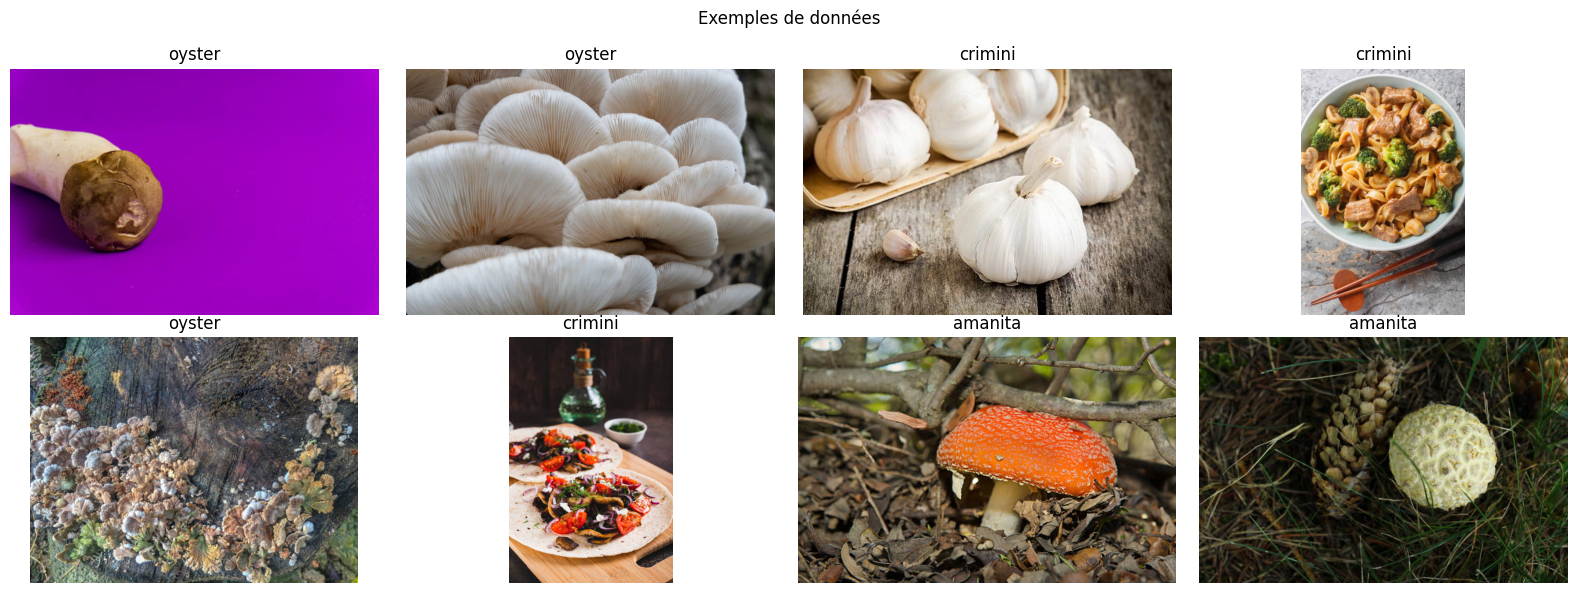

In [11]:
image_samples = np.random.randint(0,high=len(train_data)-1, size=8)

fig = plt.figure(figsize=(16,6))
for i,img_idx in enumerate(image_samples):
    axs = fig.add_subplot(2,4,i+1)
    axs.set_title(train_data[img_idx][0])
    image = Image.open(train_data[img_idx][1])
    plt.imshow(image)
    plt.axis('off')

plt.suptitle("Exemples de données")
plt.tight_layout()

## Generation de variation d'image

In [12]:
# Dimensions des images
IMG_HEIGHT = 128
IMG_WIDTH = 128
BATCH_SIZE = 32

# Générateur de données pour l'entraînement et la validation
train_datagen = ImageDataGenerator(
    rescale=1.0/255,       # Normalisation des pixels (0-1)
    rotation_range=20,     # Rotation aléatoire des images
    width_shift_range=0.2, # Décalage horizontal
    height_shift_range=0.2,# Décalage vertical
    shear_range=0.2,       # Transformation en cisaillement
    zoom_range=0.2,        # Zoom
    horizontal_flip=True,  # Flip horizontal
    fill_mode='nearest'    # Mode de remplissage
)

test_datagen = ImageDataGenerator(rescale=1.0/255)  # Normalisation uniquement

# Préparation des ensembles d'entraînement et de test
train_dir = "mushrooms"  # Chemin des données d'entraînement
test_dir = "test_mushrooms"  # Chemin des données de test

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical'  # Plusieurs classes
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

Found 15992 images belonging to 3 classes.
Found 1640 images belonging to 3 classes.


## Model

In [13]:
def create_cnn_model(input_shape, num_classes):
    model = Sequential()

    # Bloc de convolution 1
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Bloc de convolution 2
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Bloc de convolution 3
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Flatten + Fully Connected Layers
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))  # Régularisation
    model.add(Dense(num_classes, activation='softmax'))  # Couches de sortie

    return model

# Création du modèle
input_shape = (IMG_HEIGHT, IMG_WIDTH, 3)  # Images en couleur
num_classes = train_generator.num_classes
model = create_cnn_model(input_shape, num_classes)

# Compilation du modèle
model.compile(
    optimizer='adam', 
    loss='categorical_crossentropy', 
    metrics=['accuracy']
)

# Résumé du modèle
model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 63, 63, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 30, 30, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 28, 28, 128)       73856     
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 14, 14, 128)      

## Train

In [14]:
# Entraînement du modèle
EPOCHS = 20
print("GPU disponible :", tf.config.list_physical_devices('GPU'))
model = load_model('mushroom_classifier_model.h5')

history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=test_generator
)

GPU disponible : []
Epoch 1/20
500/500 [==============================] - ETA: 0s - loss: 0.7123 - accuracy: 0.6612

c:\Users\mathi\AppData\Local\Programs\Python\Python38\lib\site-packages\PIL\Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


500/500 [==============================] - 558s 1s/step - loss: 0.7123 - accuracy: 0.6612 - val_loss: 0.6432 - val_accuracy: 0.7354
Epoch 2/20
500/500 [==============================] - 223s 445ms/step - loss: 0.7100 - accuracy: 0.6606 - val_loss: 0.6877 - val_accuracy: 0.6915
Epoch 3/20
500/500 [==============================] - 222s 445ms/step - loss: 0.7044 - accuracy: 0.6629 - val_loss: 0.6018 - val_accuracy: 0.7457
Epoch 4/20
500/500 [==============================] - 223s 446ms/step - loss: 0.7092 - accuracy: 0.6601 - val_loss: 0.6781 - val_accuracy: 0.6927
Epoch 5/20
500/500 [==============================] - 222s 444ms/step - loss: 0.7050 - accuracy: 0.6643 - val_loss: 0.6460 - val_accuracy: 0.7171
Epoch 6/20
500/500 [==============================] - 222s 443ms/step - loss: 0.6992 - accuracy: 0.6697 - val_loss: 0.6756 - val_accuracy: 0.7134
Epoch 7/20
500/500 [==============================] - 221s 442ms/step - loss: 0.6930 - accuracy: 0.6731 - val_loss: 0.6190 - val_accuracy:

## Save

In [15]:
# After training your model
model.save('mushroom_classifier_model.h5')

C:\Users\mathi\AppData\Roaming\Python\Python38\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


## Load

In [16]:
model = load_model('mushroom_classifier_model.h5')

## Test

52/52 [==============================] - 15s 282ms/step - loss: 0.6713 - accuracy: 0.7402
Précision sur l'ensemble de test: 0.74


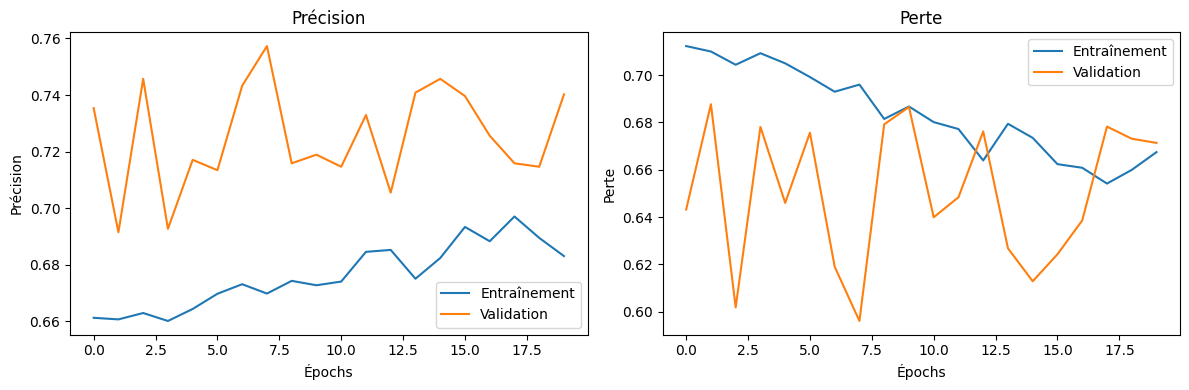

In [17]:
# Évaluation sur les données de test
test_loss, test_acc = model.evaluate(test_generator)
print(f"Précision sur l'ensemble de test: {test_acc:.2f}")

# Visualisation des courbes de précision et de perte
plt.figure(figsize=(12, 4))

# Courbe de précision
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Entraînement')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Précision')
plt.xlabel('Épochs')
plt.ylabel('Précision')
plt.legend()

# Courbe de perte
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Entraînement')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Perte')
plt.xlabel('Épochs')
plt.ylabel('Perte')
plt.legend()

plt.tight_layout()
plt.show()

Found 1640 images belonging to 3 classes.
52/52 [==============================] - 15s 295ms/step


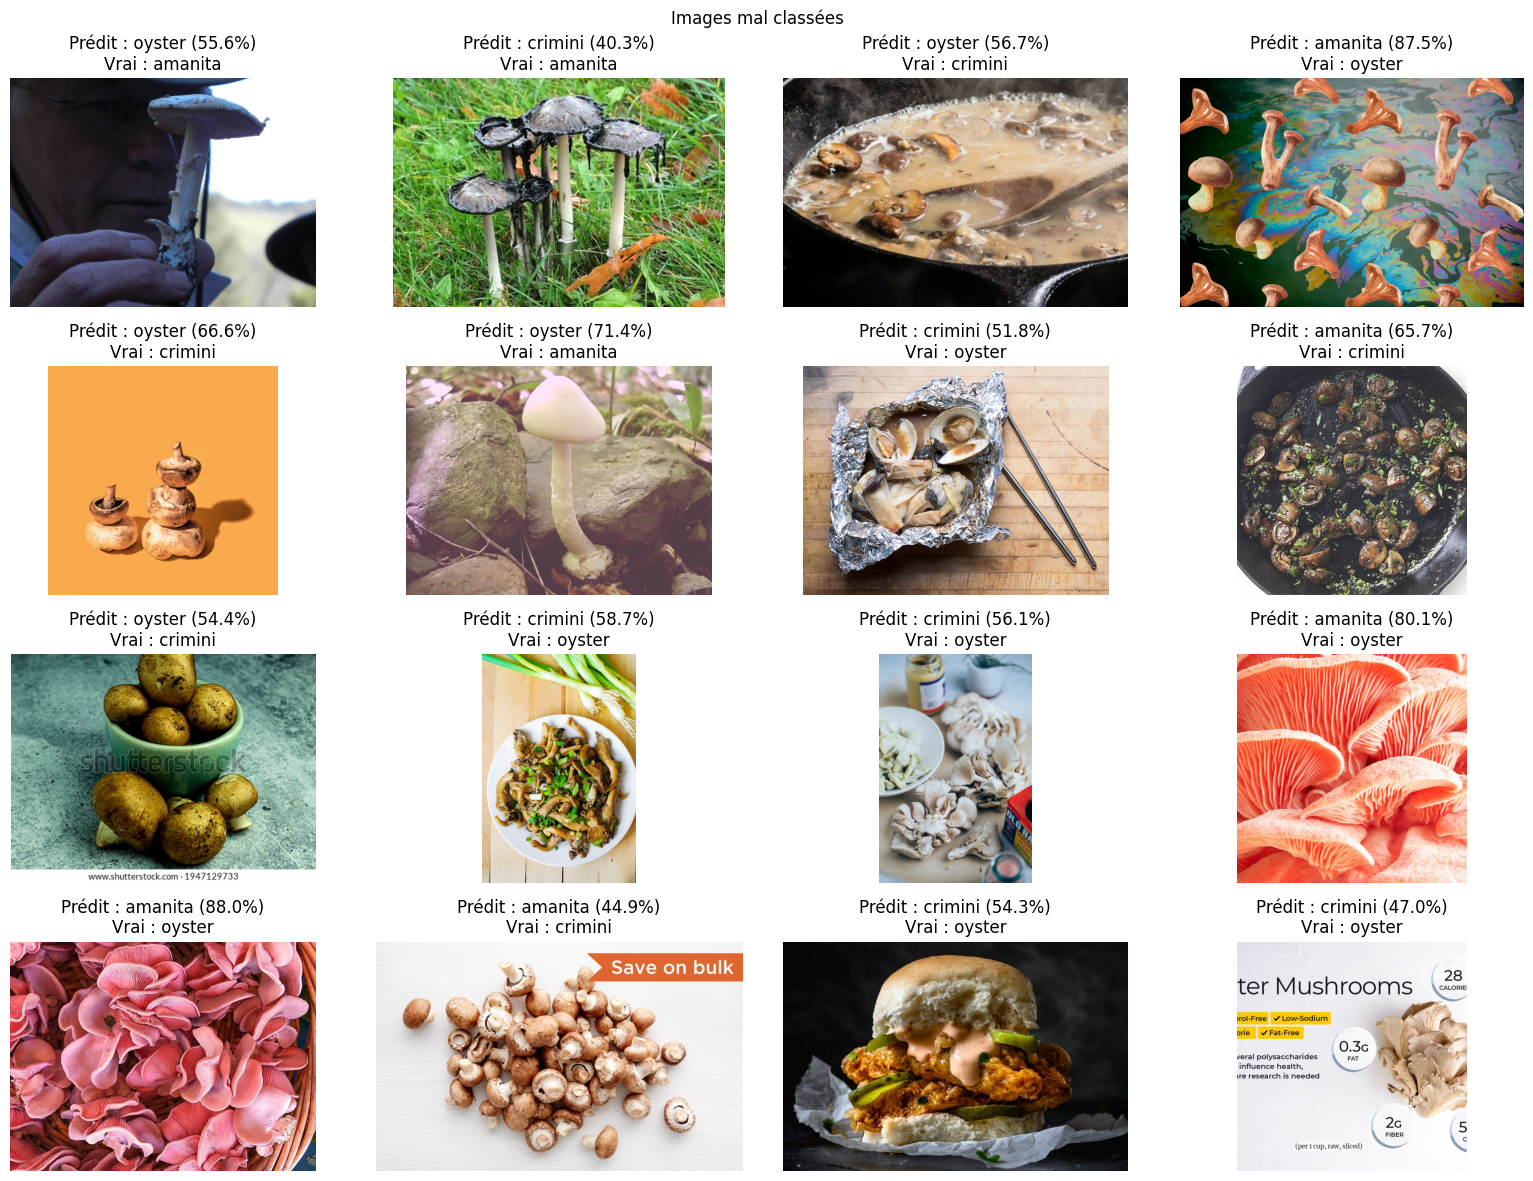

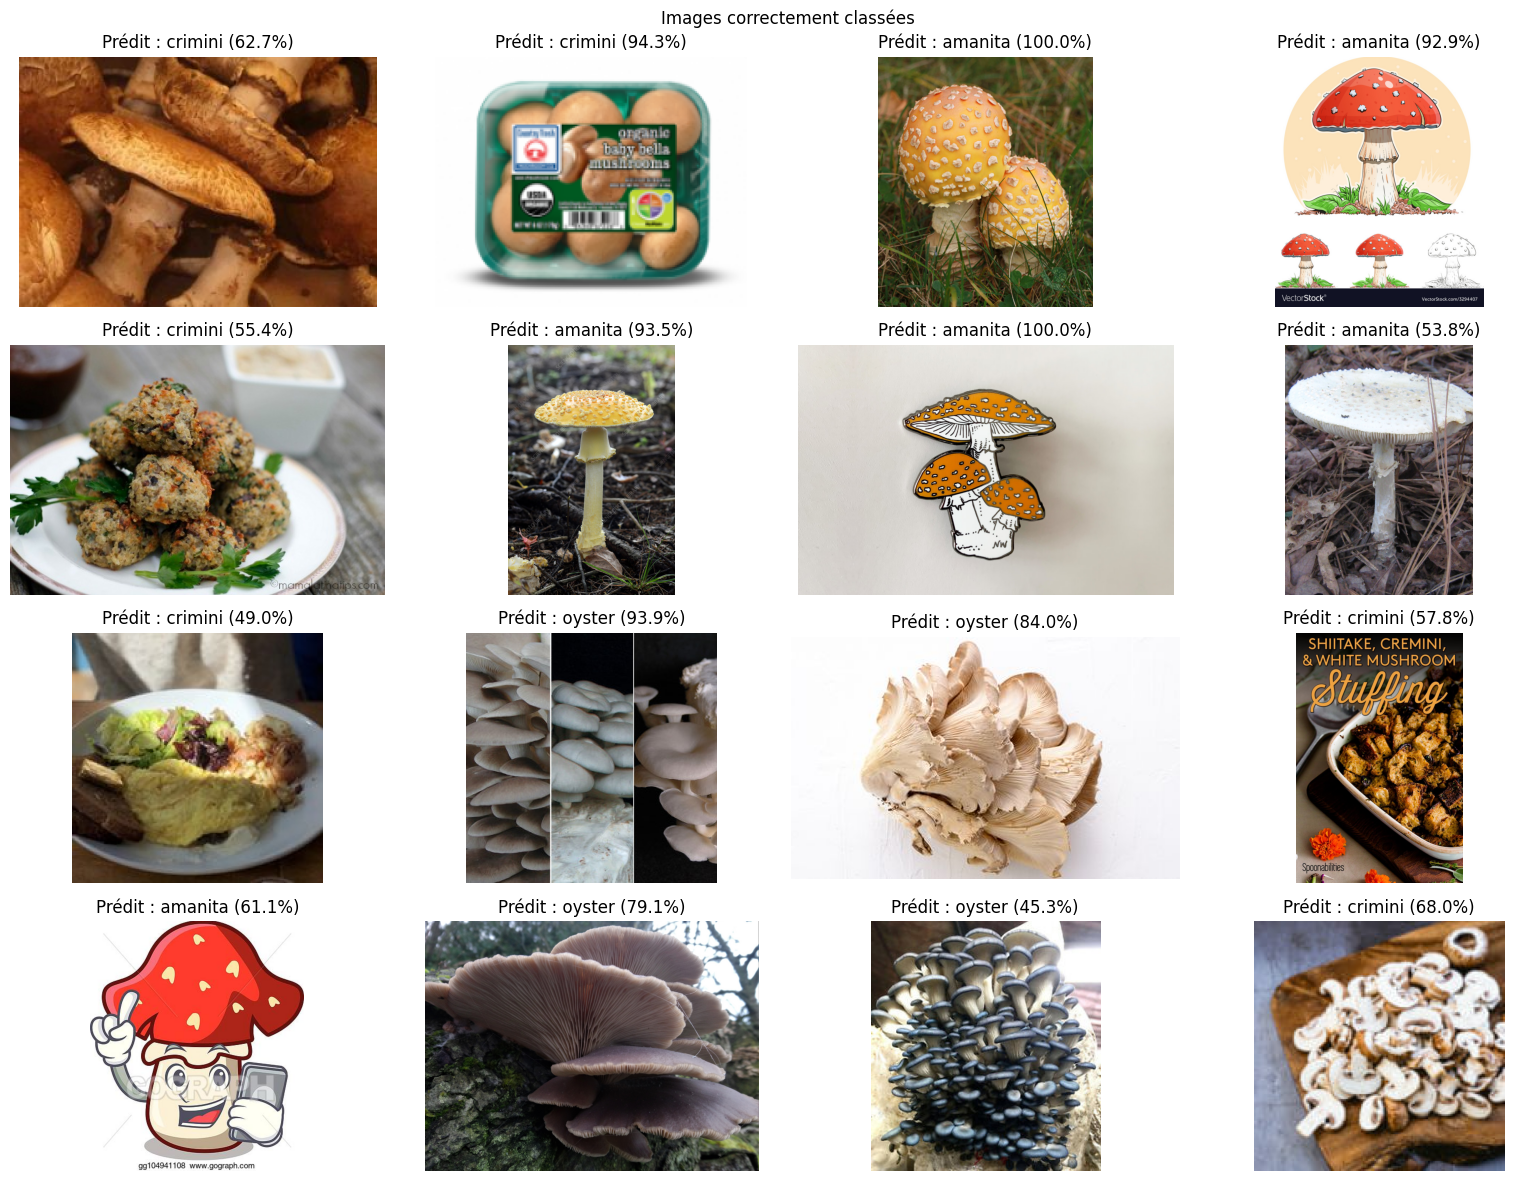

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Générateur de données pour le test
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

# Obtenir les noms des classes
class_indices = test_generator.class_indices
class_names = list(class_indices.keys())

# Prédictions du modèle sur les données de test
Y_pred = model.predict(test_generator, steps=test_generator.samples // BATCH_SIZE + 1)
y_pred = np.argmax(Y_pred, axis=1)
y_pred_confidence = np.max(Y_pred, axis=1)  # Taux de confiance pour chaque prédiction

# Étiquettes vraies
y_true = test_generator.classes

# Trouver les indices des prédictions correctes et incorrectes
correct = np.where(y_pred == y_true)[0]
incorrect = np.where(y_pred != y_true)[0]

# Fonction pour afficher les images avec le taux de confiance
def display_images(indices, title):
    num_samples = 16  # Nombre d'images à afficher
    if len(indices) < num_samples:
        num_samples = len(indices)
    image_samples = np.random.choice(indices, size=num_samples, replace=False)
    
    fig = plt.figure(figsize=(16, 12))
    for i, idx in enumerate(image_samples):
        axs = fig.add_subplot(4, 4, i+1)
        image_path = test_generator.filepaths[idx]
        image = Image.open(image_path)
        plt.imshow(image)
        
        confidence = y_pred_confidence[idx] * 100  # Convertir en pourcentage
        
        if title == "Images mal classées":
            axs.set_title(f"Prédit : {class_names[y_pred[idx]]} ({confidence:.1f}%)\nVrai : {class_names[y_true[idx]]}")
        else:
            axs.set_title(f"Prédit : {class_names[y_pred[idx]]} ({confidence:.1f}%)")
        plt.axis('off')
    
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

# Afficher des images où le modèle s'est trompé avec le taux de confiance
display_images(incorrect, "Images mal classées")

# Afficher des images où le modèle a correctement prédit avec le taux de confiance
display_images(correct, "Images correctement classées")
